# ⚽S3E26 - EDA & initial submission - Multi-Class Prediction of Cirrhosis Outcomes

Goal: use a multi-class approach to predict the the outcomes of patients with cirrhosis.  

Evaluation: Submissions are evaluated using multi-class logarithmic loss. Each id in the test set has a single true class label, Status. For each id in the test set, you must submit a set of predicted possible outcomes (e.g. "Status_C", "Status_CL", and "Status_D").

Submission: The file should contain a header and have the following format:

        id,Status_C,Status_CL,Status_D
        7905,0.628084,0.034788,0.337128
        7906,0.628084,0.034788,0.337128
        7907,0.628084,0.034788,0.337128
        etc.

## 1. Intruction

#### Why do we do this?

> Liver cirrhosis or hepatic cirrhosis, and end-stage liver disease, is the impaired liver function caused by the formation of scar tissue known as fibrosis due to damage caused by liver disease. Damage to the liver leads to repair of liver tissue and subsequent formation of scar tissue. Over time, scar tissue can replace normal functioning tissue, leading to the impaired liver function of cirrhosis. (...) 

> Cirrhosis is most commonly caused by alcoholic liver disease, non-alcoholic steatohepatitis (NASH – the progressive form of non-alcoholic fatty liver disease), heroin abuse, chronic hepatitis B, and chronic hepatitis C. Heavy drinking over a number of years can cause alcoholic liver disease. Liver damage has also been attributed to heroin usage over an extended period of time as well.
[Source: Wikipedia]

#### Data provenance

During 1974 to 1984, 424 PBC patients referred to the Mayo Clinic qualified for the randomized placebo-controlled trial testing the drug D-penicillamine. Of these, the initial 312 patients took part in the trial and have mostly comprehensive data. The remaining 112 patients didn't join the clinical trial but agreed to record basic metrics and undergo survival tracking. Six of these patients were soon untraceable after their diagnosis, leaving data for 106 of these individuals in addition to the 312 who were part of the randomized trial.

#### What we need to predict

- use a multi-class approach to predict the the outcomes of patients with liver cirrhosis

#### Evaluation

**Multi-class logarithmic loss** from each injury type and an any_injury prediction generated by the metric

$$\text{logloss} = -\frac{1}{N} \sum_{i=1}^{N} \sum_{j=1}^{M} y_ij log(p_ij) $$

where $N$ is the number of rows in the test set, $M$ is the number of outcomes (i.e. 3), $log$ is the natural logarithm, $y_ij$ is 1 if observation $i$ is in outcome $j$ and 0 otherwise, and $p_ij$ is the predicted probability that observation $i$ belongs to outcome $j$.

**The submitted probabilities for a given row are not required to sum to one** because they are rescaled prior to being scored (each row is divided by the row sum). In order to avoid the extremes of the log function, predicted probabilities are replaced with.

For each id in the test set, you must submit a set of predicted possible outcomes (e.g. "Status_C", "Status_CL", and "Status_D").

#### 📚 **Libraries**


In [2]:
# essentials
import os
import pathlib

import pandas as pd
import numpy as np
from tqdm import tqdm

# visualisation
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, log_loss

# others
import xgboost as xgb 

## 2. Exploration

#### Data Dictionary

Dataset contains 17 clinical features and 1 target variable.

| Variable | Type | Description |
| --- | --- | --- |
| Status | Categorical/Target | Status of the patient - C (censored), CL (censored due to liver tx) or D (death) |
| N_Days | Integer | Number of days between registration and the earlier of death, transplant or study analysis time (July 1986) |
| Drug | Categorical | Drug used - D-penicillamine (D) or placebo (P) |
| Age | Integer | Age (in days) |
| Sex | Categorical | (M)ale or (F)emale |
| Ascites | Categorical | Presence of ascites - Y (yes) or N (no) |
| Hepatomegaly | Categorical | Presence of hepatomegaly - Y (yes) or N (no) |
| Spiders | Categorical | Presence of spiders - Y (yes) or N (no) |
| Edema | Categorical | Presence of edema - N (no edema and no diuretic therapy for edema), S (edema present without diuretics or edema resolved by diuretics), Y (edema despite diuretic therapy) |
| Bilirubin | Float | Serum bilirubin (mg/dl) |
| Cholesterol | Integer | Serum cholesterol (mg/dl) |
| Albumin | Float | Serum albumin (gm/dl) |
| Copper | Integer | Urinary copper (ug/day) |
| Alk_Phos | Integer | Alkaline phosphatase (U/liter) |
| SGOT | Float | (serum) glutamic oxaloacetic transaminase (U/ml) |
| Triglycerides | Integer | Triglycerides |
| Platelets | Integer | Platelets per cubic (ml/1000) |
| Prothrombin | Float | Prothrombin time (s) |
| Stage | Categorical | Histologic stage of disease - 1, 2, 3, 4 |

#### Target column - Status

Target contains 3 classes: C (censored), CL (censored due to liver transplantation) or D (death).

Total number of training examples: 7905
Total number of test examples: 5271
N_Days           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
Status           0
dtype: int64


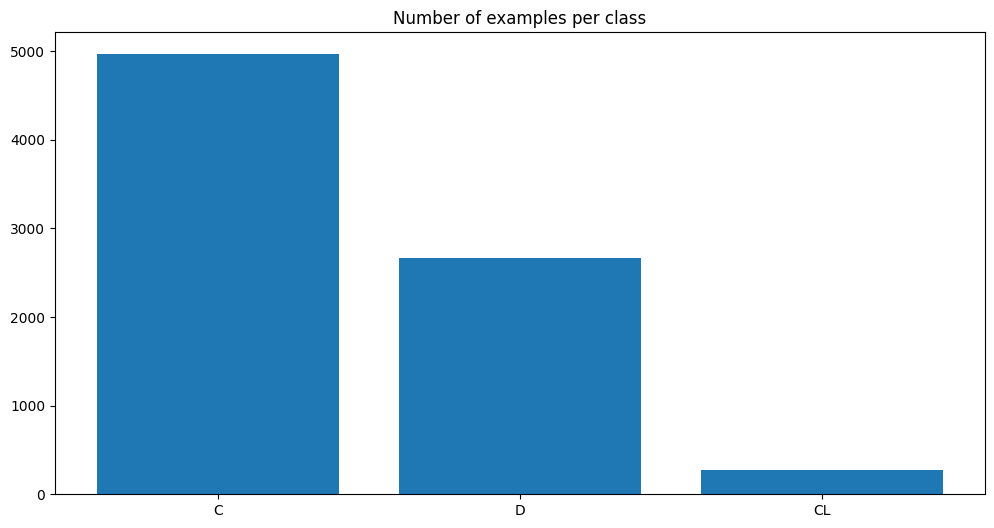

Number of examples in class C: 4965 (62.81%)
Number of examples in class D: 2665 (33.71%)
Number of examples in class CL: 275 (3.48%)


In [4]:
IN_KAGGLE = False
kaggle_folder = "/kaggle/input/playground-series-s3e26"
local_folder = "./data"
train_df = pd.read_csv(kaggle_folder if IN_KAGGLE else local_folder + "/train.csv", index_col="id")
test_df = pd.read_csv(kaggle_folder if IN_KAGGLE else local_folder  + "/test.csv", index_col="id")
target_column = "Status"

print(f"Total number of training examples: {len(train_df)}")
print(f"Total number of test examples: {len(test_df)}")
# print number of any missing values in each column
print(train_df.isnull().sum())

# plot number of different examples belonging to each target_column values, by value and by percentage

fig, ax = plt.subplots(1, 1, figsize=(12, 6))


total_examples = len(train_df)
number_of_examples = train_df[target_column].value_counts().values
labels = train_df[target_column].value_counts().index
percentages = []

for number in number_of_examples:
    percentages.append(number/total_examples)

ax.title.set_text("Number of examples per class")
ax.bar(labels, number_of_examples)

plt.show()

for label, value, percentage in zip(labels, number_of_examples, percentages):
    print(f"Number of examples in class {label}: {value} ({percentage*100:.2f}%)")

> There are no missing values

### Categorical features

| Variable | Type | Description |
| --- | --- | --- |
| Drug | Categorical | Drug used - D-penicillamine (D) or placebo (P) |
| Sex | Categorical | (M)ale or (F)emale |
| Ascites | Categorical | Presence of ascites - Y (yes) or N (no) |
| Hepatomegaly | Categorical | Presence of hepatomegaly - Y (yes) or N (no) |
| Spiders | Categorical | Presence of spiders - Y (yes) or N (no) |
| Edema | Categorical | Presence of edema - N (no edema and no diuretic therapy for edema), S (edema present without diuretics or edema resolved by diuretics), Y (edema despite diuretic therapy) |
| Stage | Categorical | Histologic stage of disease - 1, 2, 3, 4 |

In [4]:
categorical_features = ["Drug", "Sex", "Ascites", "Hepatomegaly", "Spiders", "Edema", "Stage"]

train_df[categorical_features].info()

<class 'pandas.core.frame.DataFrame'>
Index: 7905 entries, 0 to 7904
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Drug          7905 non-null   object 
 1   Sex           7905 non-null   object 
 2   Ascites       7905 non-null   object 
 3   Hepatomegaly  7905 non-null   object 
 4   Spiders       7905 non-null   object 
 5   Edema         7905 non-null   object 
 6   Stage         7905 non-null   float64
dtypes: float64(1), object(6)
memory usage: 494.1+ KB


#### Distribution of categorical features

/home/wiktor/.pyenv/versions/3.10.11/envs/kaggling/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


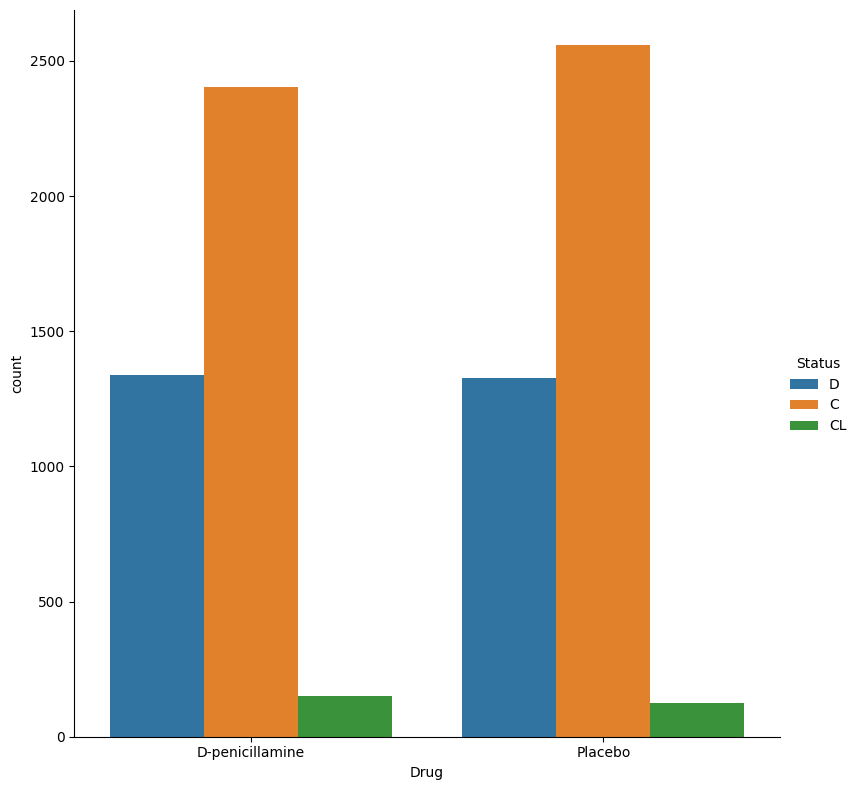

In [5]:
sns.catplot(
    data=train_df, x="Drug", hue=target_column, kind="count", height=8,
)

/home/wiktor/.pyenv/versions/3.10.11/envs/kaggling/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


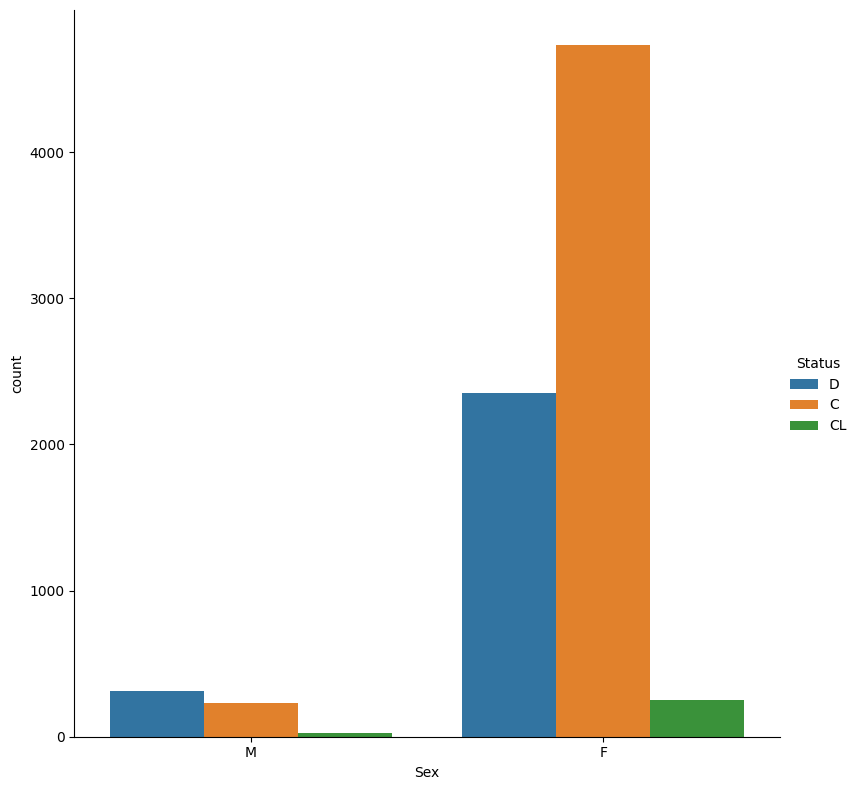

In [6]:
sns.catplot(
    data=train_df, x="Sex", hue=target_column, kind="count", height=8,
)

/home/wiktor/.pyenv/versions/3.10.11/envs/kaggling/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


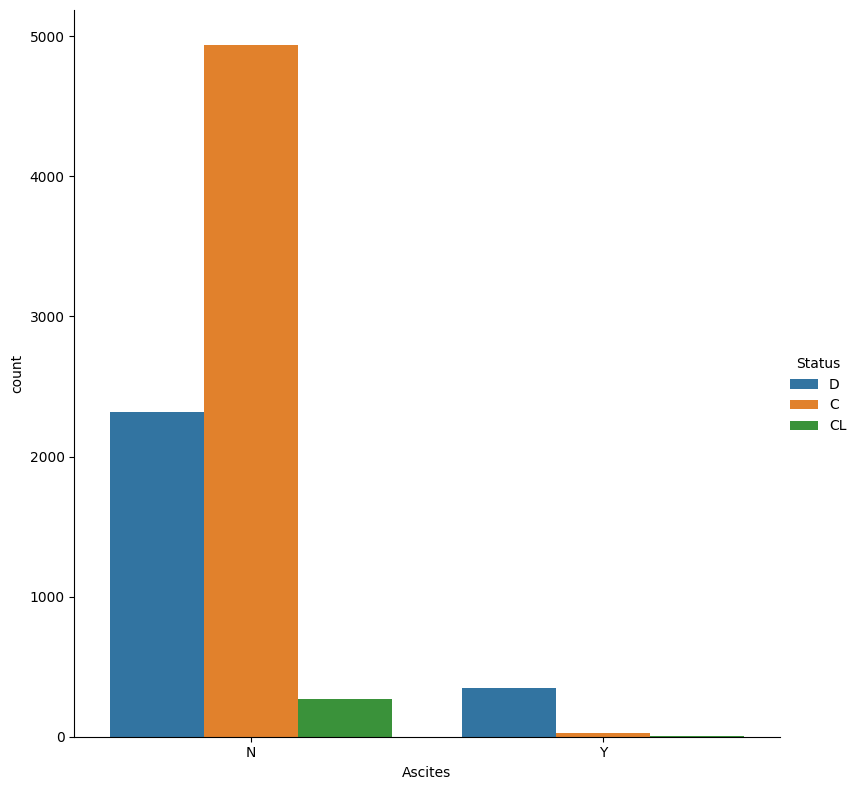

In [7]:
sns.catplot(
    data=train_df, x="Ascites", hue=target_column, kind="count", height=8,
)

/home/wiktor/.pyenv/versions/3.10.11/envs/kaggling/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


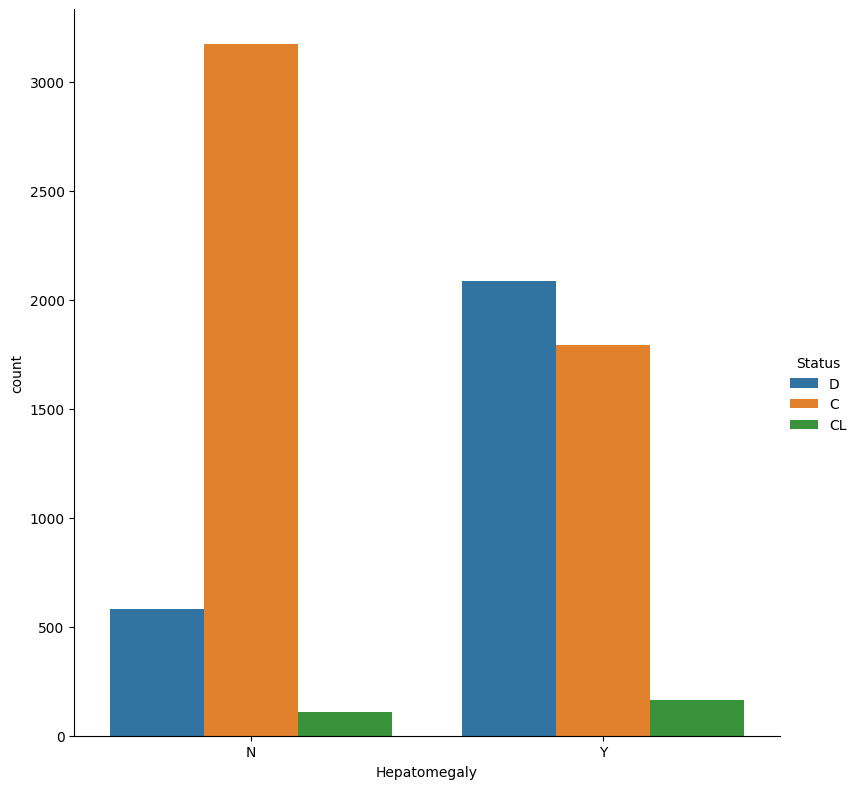

In [8]:
sns.catplot(
    data=train_df, x="Hepatomegaly", hue=target_column, kind="count", height=8,
)

/home/wiktor/.pyenv/versions/3.10.11/envs/kaggling/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


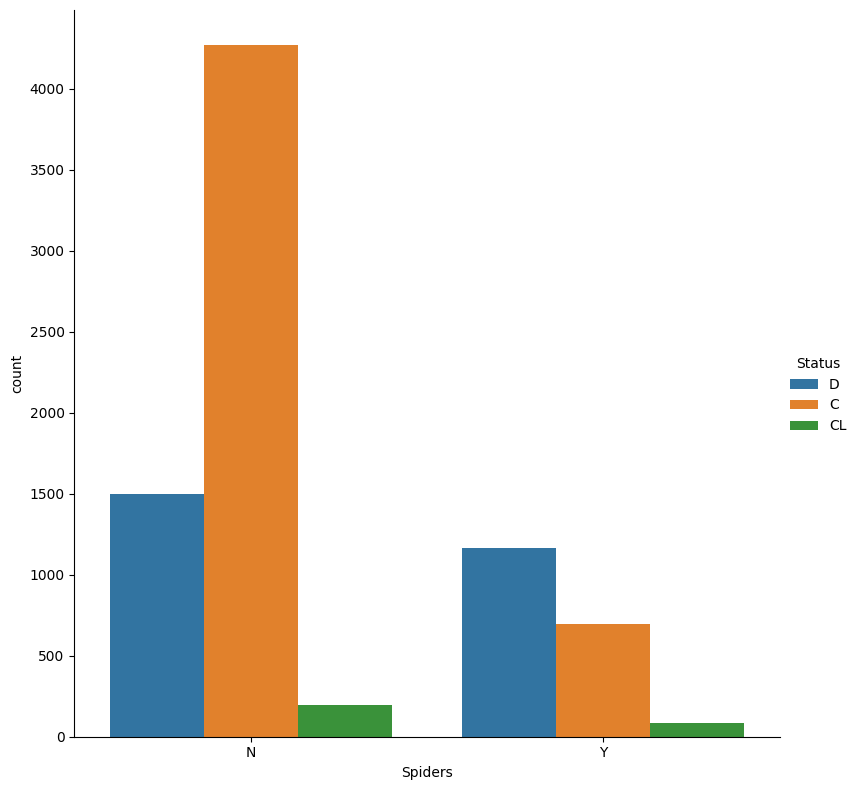

In [9]:
sns.catplot(
    data=train_df, x="Spiders", hue=target_column, kind="count", height=8,
)

/home/wiktor/.pyenv/versions/3.10.11/envs/kaggling/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


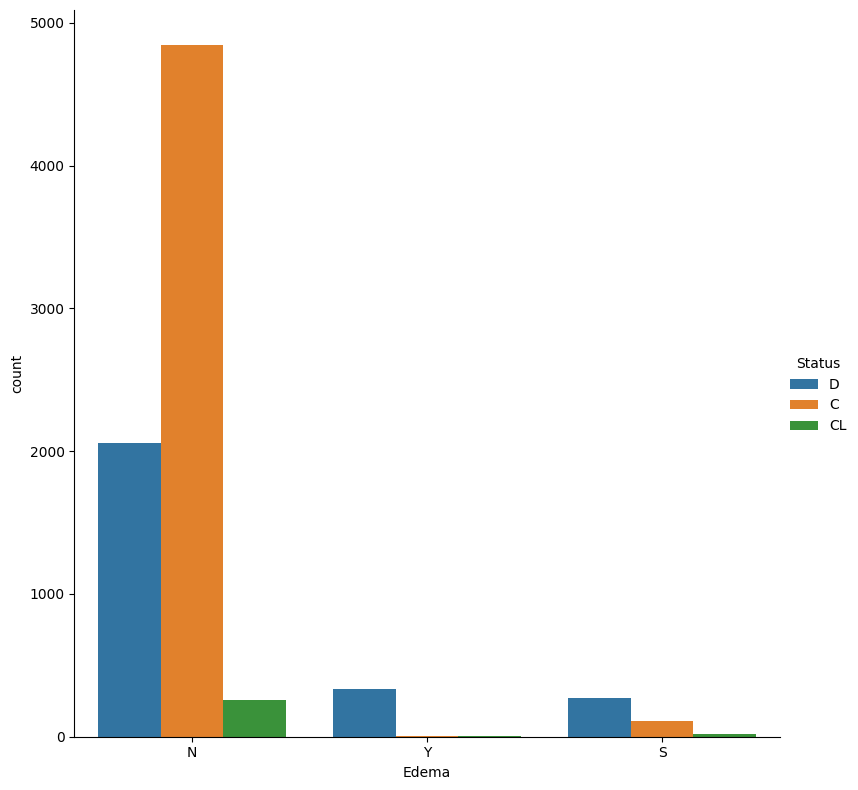

In [10]:
sns.catplot(
    data=train_df, x="Edema", hue=target_column, kind="count", height=8,
)

/home/wiktor/.pyenv/versions/3.10.11/envs/kaggling/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


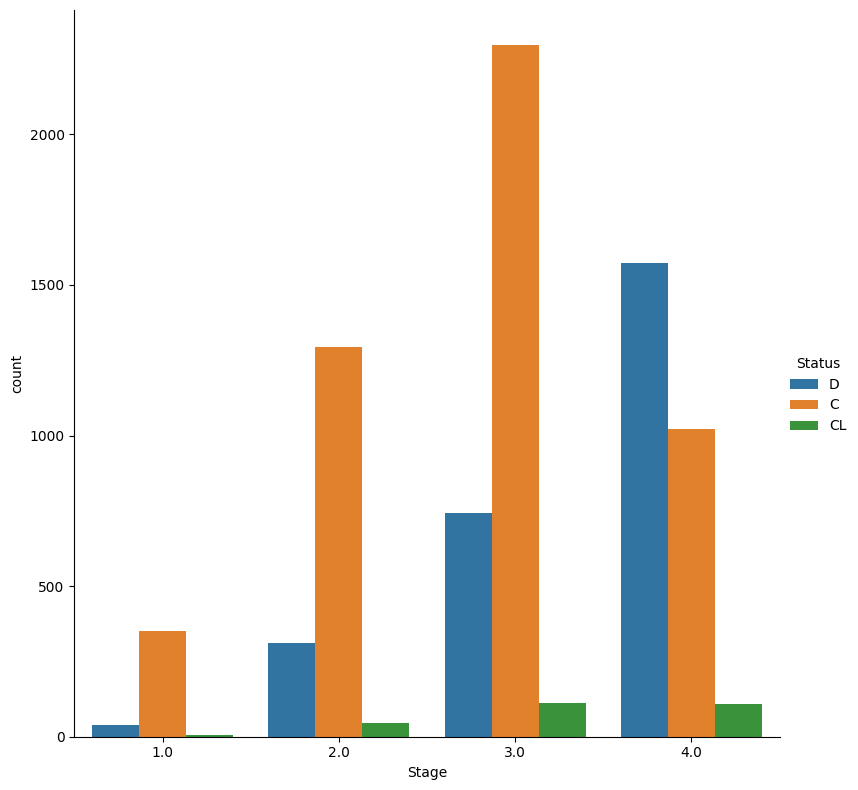

In [11]:
sns.catplot(
    data=train_df, x="Stage", hue=target_column, kind="count", height=8,
)

/home/wiktor/.pyenv/versions/3.10.11/envs/kaggling/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


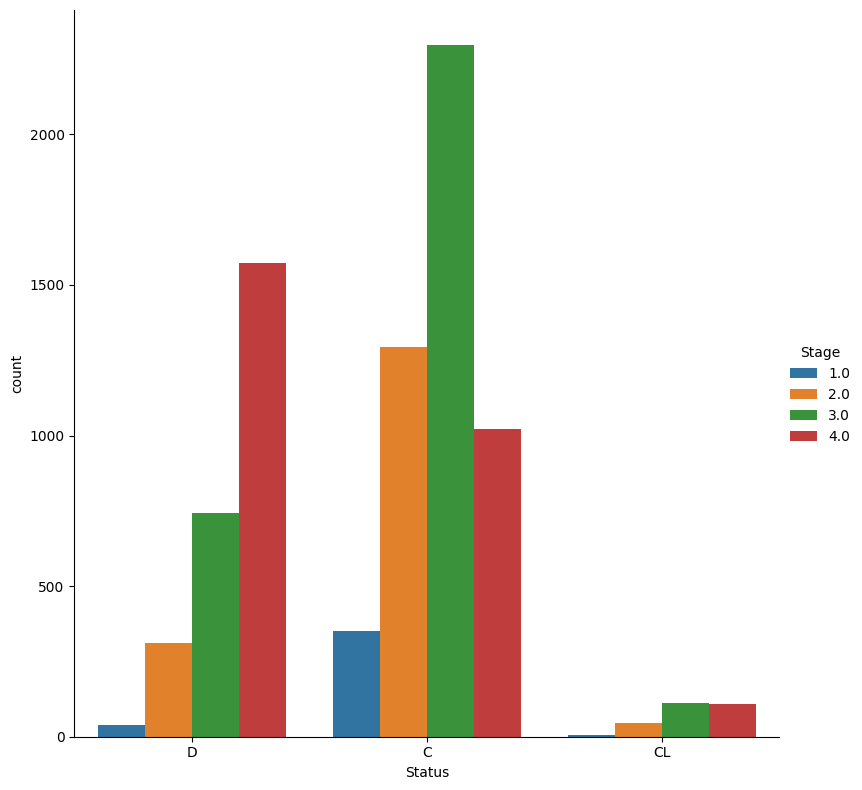

In [12]:
sns.catplot(
    data=train_df, x=target_column, hue="Stage", kind="count", height=8,
)

#### Numerical features

In [13]:
numerical_features = ["N_Days", "Age", "Bilirubin", "Cholesterol", "Albumin", "Copper", "Alk_Phos", "SGOT", "Tryglicerides", "Platelets", "Prothrombin"]

train_df[numerical_features].info()

<class 'pandas.core.frame.DataFrame'>
Index: 7905 entries, 0 to 7904
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         7905 non-null   int64  
 1   Age            7905 non-null   int64  
 2   Bilirubin      7905 non-null   float64
 3   Cholesterol    7905 non-null   float64
 4   Albumin        7905 non-null   float64
 5   Copper         7905 non-null   float64
 6   Alk_Phos       7905 non-null   float64
 7   SGOT           7905 non-null   float64
 8   Tryglicerides  7905 non-null   float64
 9   Platelets      7905 non-null   float64
 10  Prothrombin    7905 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 741.1 KB


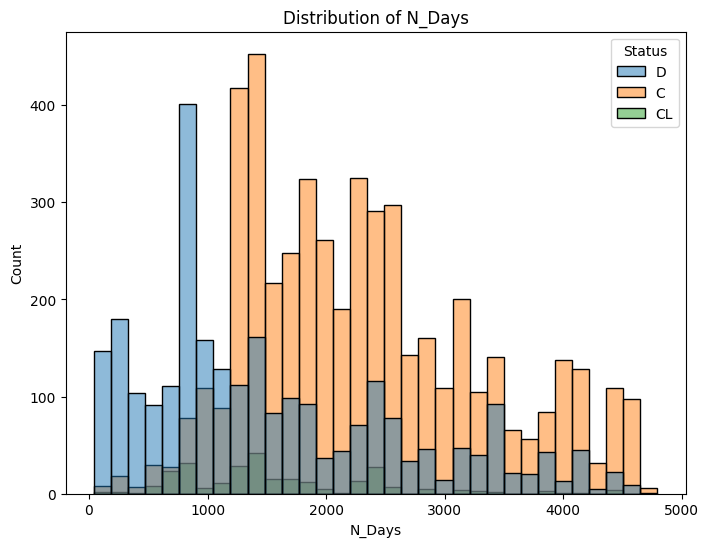

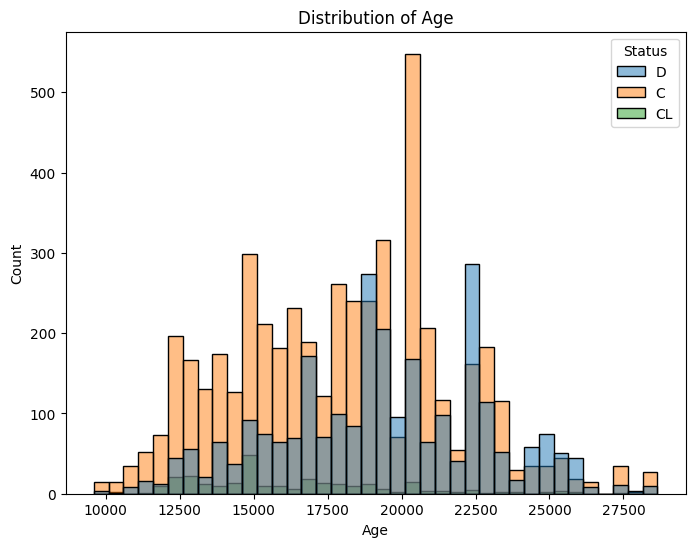

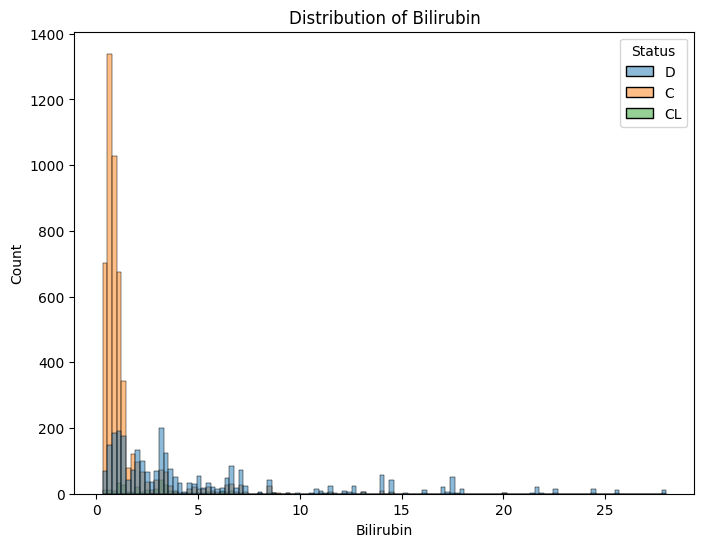

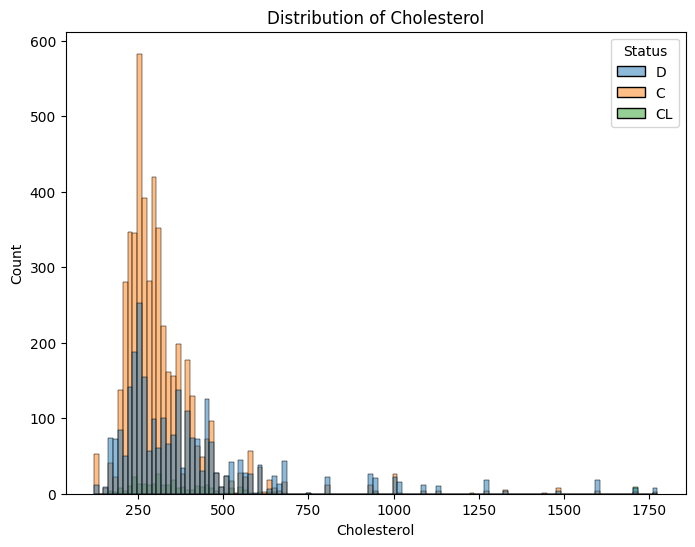

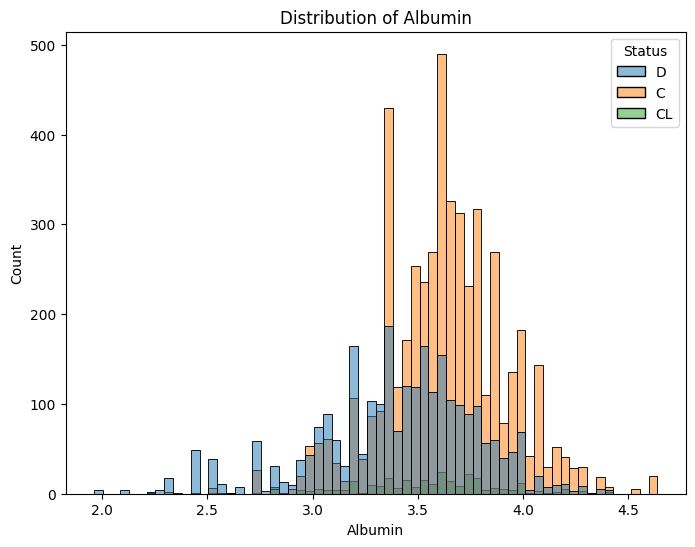

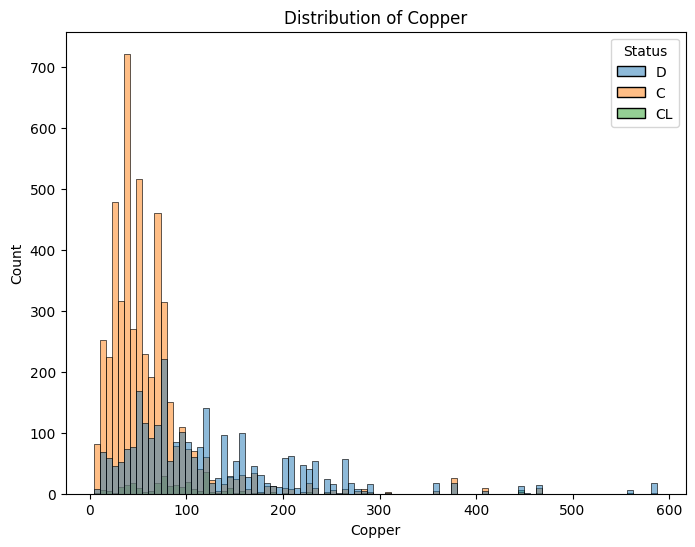

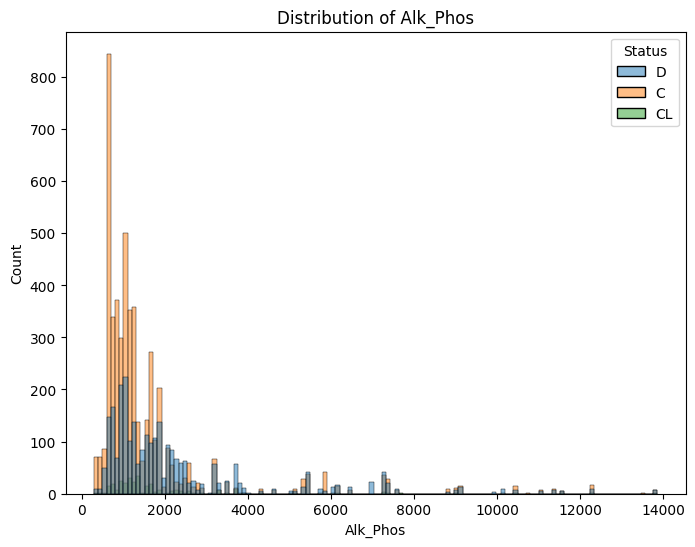

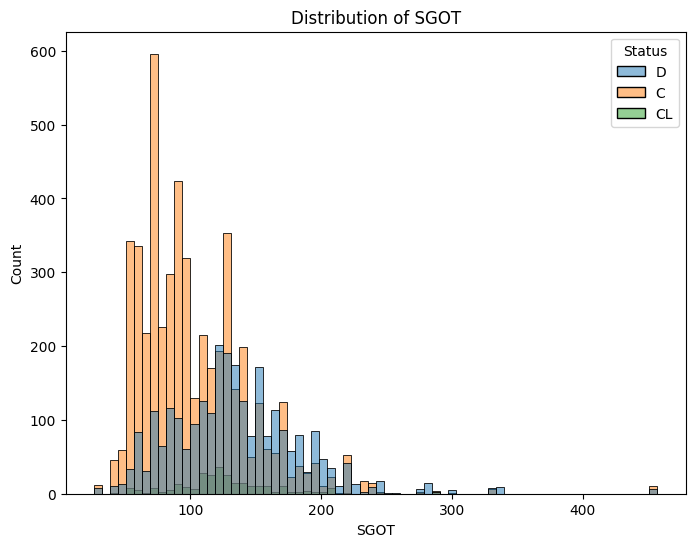

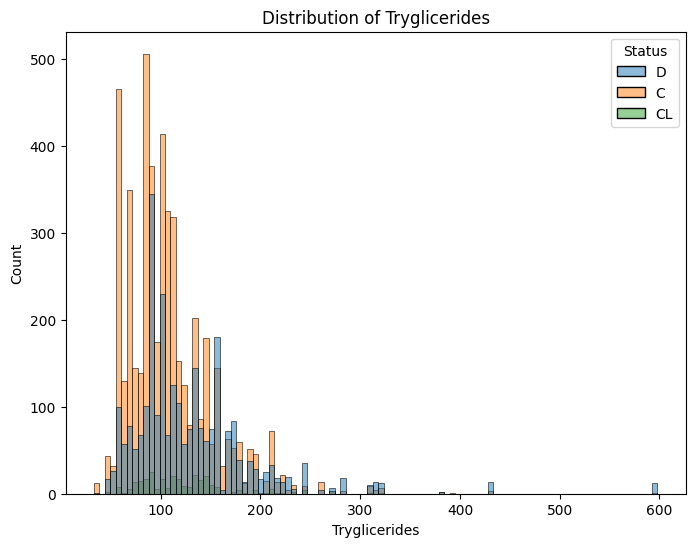

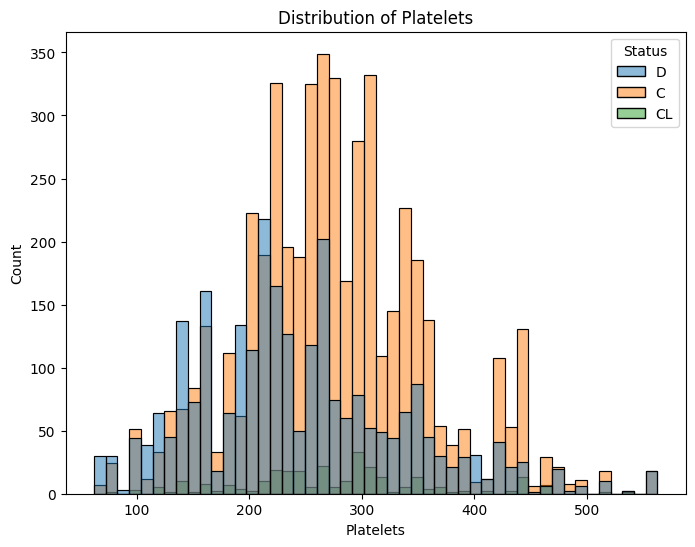

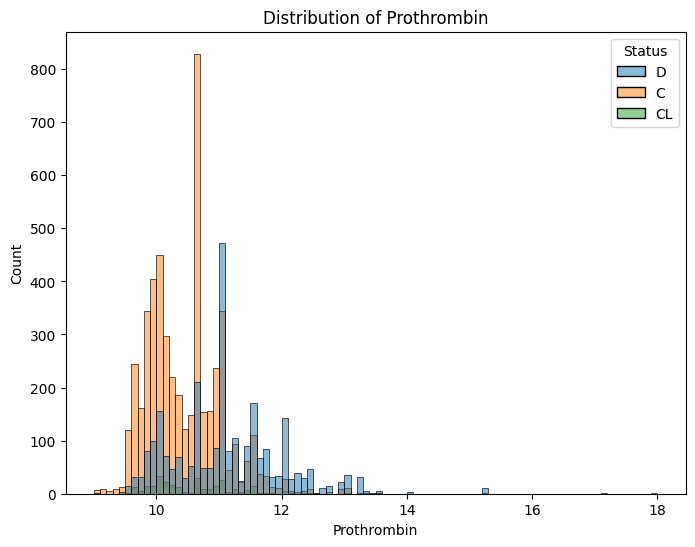

In [14]:
for feature in numerical_features:
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.title.set_text(f"Distribution of {feature}")
    sns.histplot(data=train_df, x=feature, hue=target_column, ax=ax)
    plt.show()

### Correlations

#### Correlation between numerical features

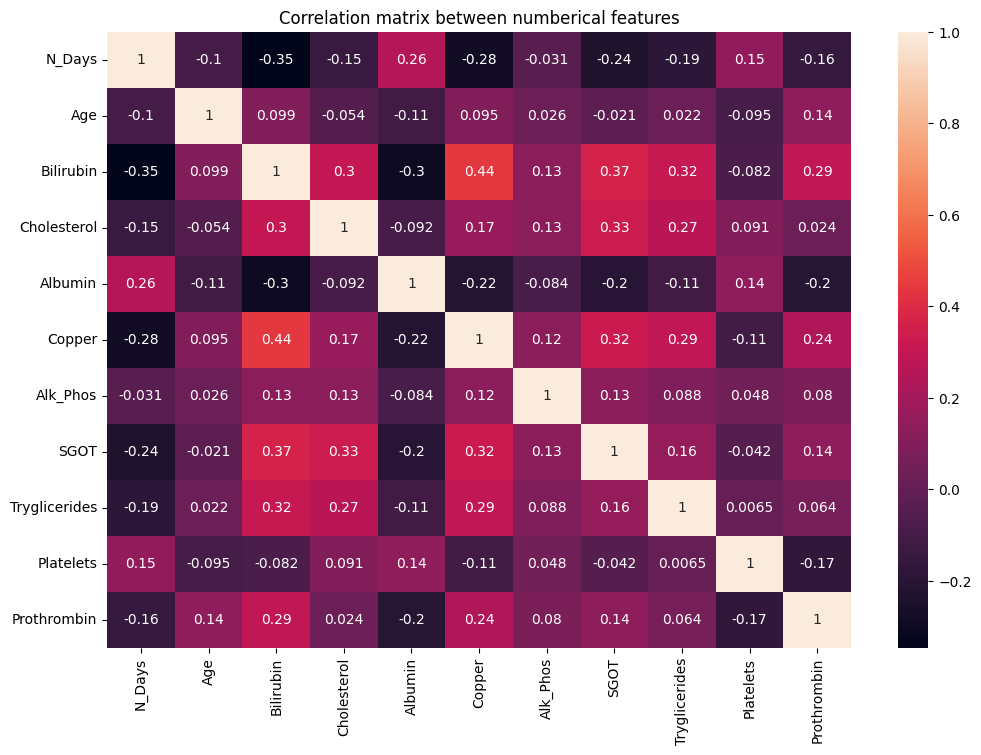

In [15]:
# create a correlation matrix and show on heatmap
corr_matrix = train_df[numerical_features].corr()

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.title.set_text("Correlation matrix between numberical features")
sns.heatmap(corr_matrix, annot=True, ax=ax)
plt.show()

In [16]:
# what are biggest correlations between features?
abs_corr_matrix = corr_matrix.abs()
abs_corr_matrix = abs_corr_matrix.where(np.triu(np.ones(abs_corr_matrix.shape), k=1).astype(np.bool_))
abs_corr_matrix = abs_corr_matrix.stack().reset_index()
abs_corr_matrix.columns = ["Feature 1", "Feature 2", "Correlation"]
abs_corr_matrix.dropna(inplace=True)
abs_corr_matrix.sort_values(by="Correlation", ascending=False).head(10)

,Feature 1,Feature 2,Correlation
21,Bilirubin,Copper,0.442223
23,Bilirubin,SGOT,0.368653
1,N_Days,Bilirubin,0.346434
30,Cholesterol,SGOT,0.326864
41,Copper,SGOT,0.323226
24,Bilirubin,Tryglicerides,0.315681
20,Bilirubin,Albumin,0.303191
19,Bilirubin,Cholesterol,0.302153
26,Bilirubin,Prothrombin,0.294325
42,Copper,Tryglicerides,0.290435


In [17]:
abs_corr_matrix.sort_values(by="Correlation", ascending=True).head(10)

,Feature 1,Feature 2,Correlation
52,Tryglicerides,Platelets,0.006511
15,Age,SGOT,0.020768
16,Age,Tryglicerides,0.021767
33,Cholesterol,Prothrombin,0.023761
14,Age,Alk_Phos,0.025879
5,N_Days,Alk_Phos,0.030874
50,SGOT,Platelets,0.042004
47,Alk_Phos,Platelets,0.047869
11,Age,Cholesterol,0.053876
53,Tryglicerides,Prothrombin,0.063582


#### Chi-square comparison of categorical features between three classes

> todo

## Initial submission

#### Train val split

In [18]:
X = train_df.drop(columns=target_column)
y = train_df[target_column]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y, shuffle=True)

print(f"Number of training examples: {len(X_train)}")
print(f"Number of validation examples: {len(X_val)}")

print("Number of examples per class in training set")
print(y_train.value_counts())

print("Number of examples per class in validation set")
print(y_val.value_counts())

le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

Number of training examples: 7114
Number of validation examples: 791
Number of examples per class in training set
Status
C     4468
D     2398
CL     248
Name: count, dtype: int64
Number of examples per class in validation set
Status
C     497
D     267
CL     27
Name: count, dtype: int64


In [19]:
from sklearn.utils import compute_sample_weight

sw = compute_sample_weight(class_weight="balanced", y=y_train)

In [20]:
numeric_transformer = Pipeline(
    [
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    [
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

clf = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", xgb.XGBClassifier(objective="multi:softprob", random_state=42)),
    ]
)

kwargs = {clf.steps[-1][0] + '__sample_weight': sw}

clf.fit(X_train, y_train, **kwargs)
y_pred_proba = clf.predict_proba(X_val)
y_pred = clf.predict(X_val)

print(f"Log loss: {log_loss(y_val, y_pred_proba)}")
print(classification_report(y_val, y_pred, target_names=le.classes_))

Log loss: 0.5339125322809191
              precision    recall  f1-score   support

           C       0.86      0.89      0.87       497
          CL       0.54      0.26      0.35        27
           D       0.78      0.79      0.78       267

    accuracy                           0.83       791
   macro avg       0.73      0.64      0.67       791
weighted avg       0.83      0.83      0.83       791



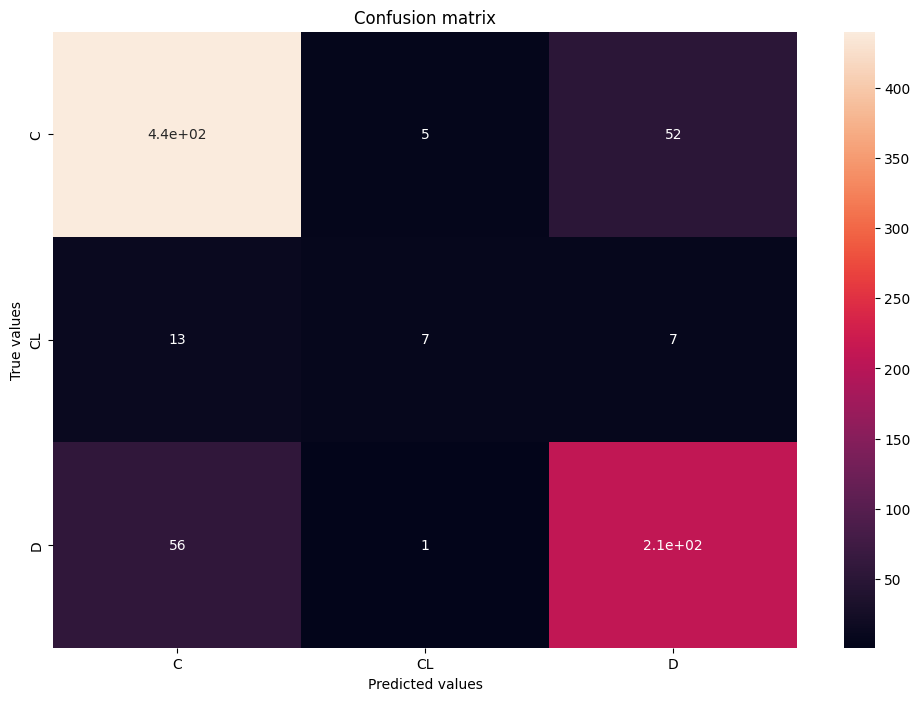

In [21]:
# visualise confusion matrix

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.title.set_text("Confusion matrix")
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, ax=ax)
ax.set_xticklabels(le.classes_)
ax.set_yticklabels(le.classes_)

# show on top of heatmap text "Predicted values"
ax.set_xlabel("Predicted values")
ax.set_ylabel("True values")
plt.show()

#### Retrain on full train set & submit

In [22]:
train_df = pd.read_csv("./data/train.csv", index_col="id")
test_df = pd.read_csv("./data/test.csv", index_col="id")

X_train = train_df.drop(columns=target_column)
y_train = le.transform(train_df[target_column])

X_test = test_df

clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)

submission_df = pd.DataFrame(y_pred, index=X_test.index, columns=[f"Status_{target}" for target in le.classes_])
submission_df.to_csv("./submission.csv")
submission_df

,Status_C,Status_CL,Status_D
id,,,
7905,0.239154,0.020699,0.740147
7906,0.583972,0.123805,0.292223
7907,0.003447,0.000648,0.995905
7908,0.982170,0.001438,0.016392
7909,0.902893,0.021016,0.076091
...,...,...,...
13171,0.955195,0.028716,0.016088
13172,0.998370,0.000107,0.001523
13173,0.887271,0.002416,0.110313
